## Retail Project

In [1]:
# Gemeral
import numpy as np
import pandas as pd
import nltk
import random

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

#Performance
%load_ext memory_profiler

# Extra
from os import path
from PIL import Image

# Model = np.array(Image.open("model.png"))
# Failed attempted at adding a form to wordcloud

In [66]:
# Read
data = pd.ExcelFile("retail dataset.xlsx")
df = data.parse("Sheet1", header=1)
df = df.drop(["Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21","Unnamed: 22","Unnamed: 23","Unnamed: 24","Unnamed: 25","Unnamed: 26"], axis = 1)
df["LABEL"] = 0
df.loc[df.RATING >= 3,"LABEL"] = 1

In [42]:
print(df.head())
df.info()

  STERLINGEXTERNALALIAS  AGE              IID  REVIEW_ID  \
0              40175747   33  100008000000000   73990099   
1         4130200000000   34  100000000000000   67591147   
2         4130080000000   60  100000000000000   56579841   
3         4123200000000   50  100001000000000   56445604   
4         4110530000000   47  100001000000000   73214993   

                     TITLE                                        REVIEW_TEXT  \
0                      NaN  absolutely wonderful - silky and sexy and comf...   
1                      NaN  Love this dress!  It's sooo pretty.  I happene...   
2  Some major design flaws  I had such high hopes for this dress and reall...   
3         My Favorite Buy!  I love, love, love this jumpsuit. It's fun, fl...   
4         Flattering shirt  This shirt is very flattering to all due to th...   

   RATING  RATING_RANGE  RECOMMENDED_IND  NUM_FEEDBACKS  \
0       4             5                1              0   
1       5             5           

## PreProcessing

In [69]:
ps = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ')
    words = tokenizer.tokenize(txt)
    words = [w for w in words if not w in stop_words]
    #words = [ps.stem(w) for w in words] #Stemmed version
    return words

## Functions

In [46]:
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    
# https://www.kaggle.com/longdoan/word-cloud-with-python
# https://github.com/amueller/word_cloud/issues/134
# https://amueller.github.io/word_cloud/auto_examples/masked.html

def cloud(text):
    mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
    mpl.rcParams['font.size']=12                #10 
    mpl.rcParams['savefig.dpi']=100             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 

    stopwords = set(STOPWORDS) # Redundant
    
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))

    print(wordcloud)

    fig = plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    #fig.savefig("word1.png", dpi=900)

## General Analysis

In [80]:
print(pd.crosstab(df['RATING'], df['CLASS_NAME']))
print(df[['CLASS_NAME', 'LABEL']].groupby(['CLASS_NAME'], as_index=False).mean())

CLASS_NAME  BLOUSES - ANTHRO. (NA)  BLOUSES - PETITES (NA)  \
RATING                                                       
1                               74                      45   
2                              155                      74   
3                              254                     140   
4                              441                     228   
5                             1069                     617   

CLASS_NAME  CASUAL BOTTOMS (NA)  CHEMISES (NA)  CUT AND SEW KNITS-ANTHRO (NA)  \
RATING                                                                          
1                             0              0                            128   
2                             0              0                            220   
3                             0              0                            433   
4                             1              1                            768   
5                             1              0                           1710  

In [79]:
print(pd.crosstab(df['RATING'], df['DEPARTMENT_NAME']))
print(df[['DEPARTMENT_NAME', 'LABEL']].groupby(['DEPARTMENT_NAME'], as_index=False).mean())

DEPARTMENT_NAME  ANTHRO WOMEN'S TREND (NA)  ANTHRO. WOMEN'S BOTTOMS (NA)  \
RATING                                                                     
1                                        9                            75   
2                                       10                           147   
3                                       13                           296   
4                                       21                           526   
5                                       43                          1498   

DEPARTMENT_NAME  ANTHRO. WOMEN'S INTIMATE (NA)  ANTHRO. WOMEN'S OTHER (NA)  \
RATING                                                                       
1                                           54                         122   
2                                           77                         262   
3                                          155                         525   
4                                          315                         798   

## Simple Viz

## Word Distribution and Word Cloud

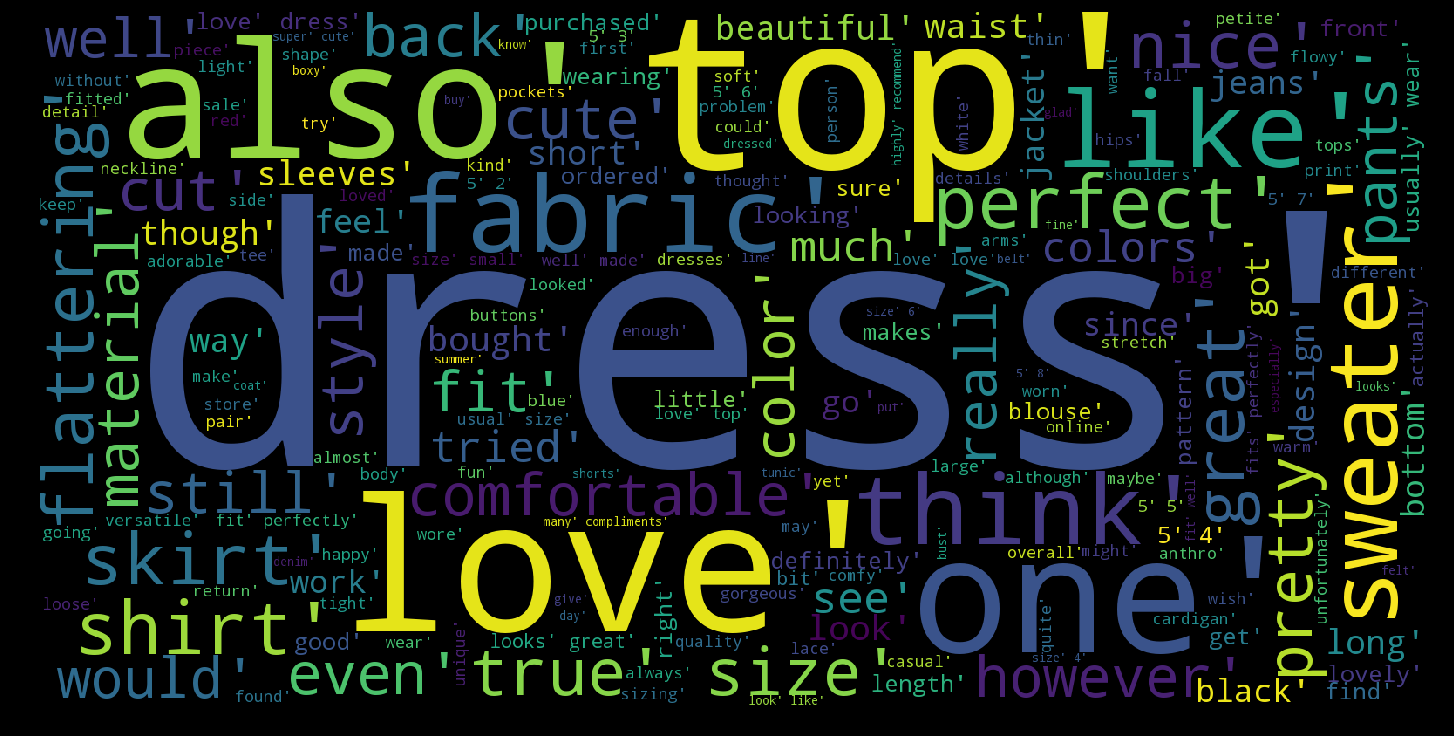

None


In [73]:
# Highly Raited
out = preprocessing(df[df.RATING >= 3]['REVIEW_TEXT'])
#print(wordfreq(out,20))
print(cloud(out))
#print(wordfreqviz(out,10))

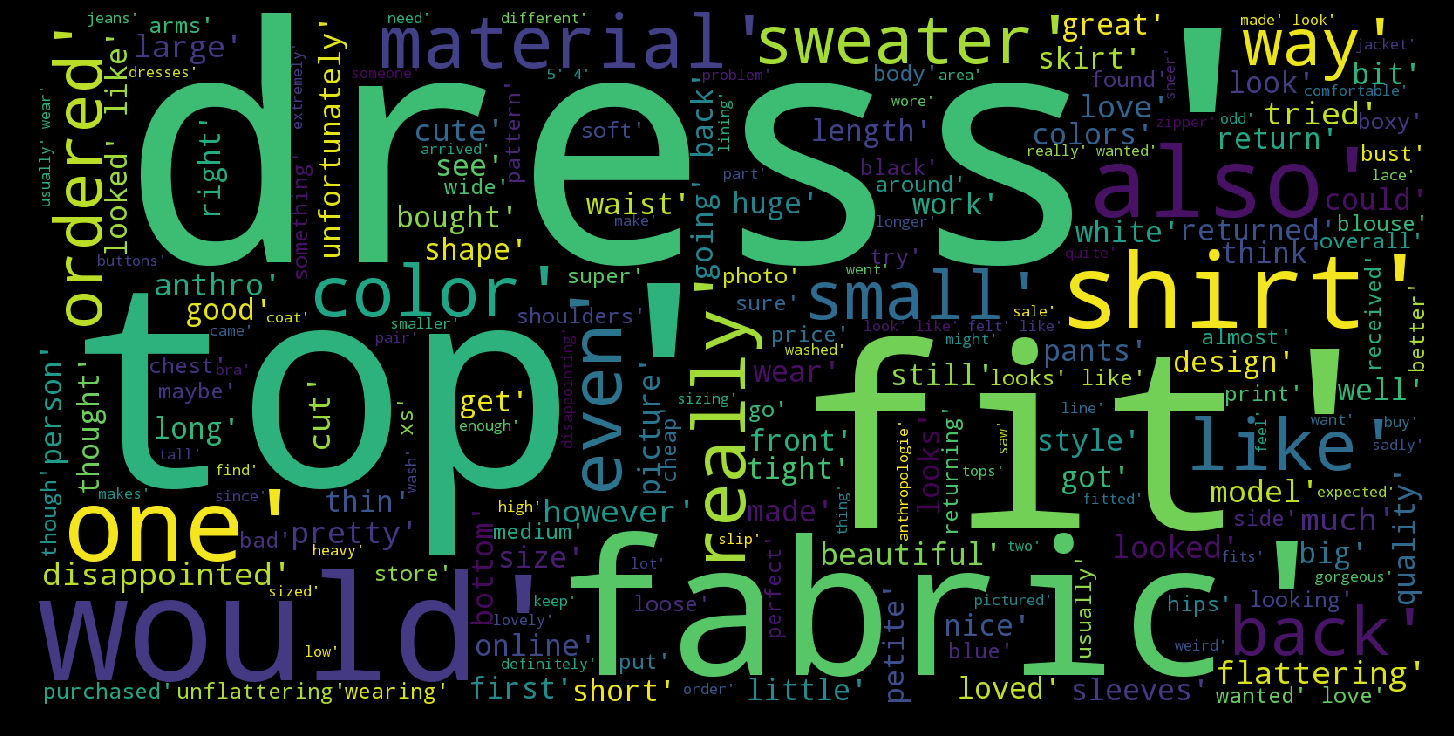

None


In [74]:
# Low Raited
out = preprocessing(df[df.RATING < 3]['REVIEW_TEXT'])
#print(wordfreq(out,20))
print(cloud(out))
#print(wordfreqviz(out,10))

## Supervised Learning

In [72]:
all_text = preprocessing(df['REVIEW_TEXT'])
data = df[["LABEL", "REVIEW_TEXT"]]
data['text'] = data.REVIEW_TEXT.astype(str).str.lower() # turn into lower case text
data['text'] = data.apply(lambda row: tokenizer.tokenize(row['text']), axis=1) # apply tokenize to each row
data['text'] = data['text'].apply(lambda x: [w for w in x if not w in stop_words]) # remove stopwords from each row
#data['text'] = data['text'].apply(lambda x: [ps.stem(w) for w in x]) # apply stemming to each row
all_words = nltk.FreqDist(all_text) # calculate word occurence from whole block of text
word_features= list(all_words.keys())[:3000] # 5000 most recurring unique words

D:\WindowsApps\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\WindowsApps\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\WindowsApps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [14]:
data = data.drop("REVIEW_TEXT", axis=1)
data[:5]

,LABEL,text
0,1,"[absolutely, wonderful, silky, sexy, comfortable]"
1,1,"[love, dress, sooo, pretty, happened, find, st..."
2,1,"[high, hopes, dress, really, wanted, work, ini..."
3,1,"[love, love, love, jumpsuit, fun, flirty, fabu..."
4,1,"[shirt, flattering, due, adjustable, front, ti..."


In [15]:
data.to_csv("modeldata.csv", header=True, index=False)

In [16]:
labtext= list(zip(data.text, (data.LABEL))) 
# Tuple each review with its label (1= greater/equal to 3, 0= under 3)

In [17]:
labtext[0]

(['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable'], 1)

In [18]:
# Function to create model features
# for each review, records which uniqeue words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

In [19]:
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

23486

In [20]:
print(type(featuresets))

<class 'list'>


In [21]:
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

## Naive Bayes

In [22]:
%%time
%%memit
classifier = nltk.NaiveBayesClassifier.train(training_set) # Very scalable algorithm
# Posterior = prior_occurence * likelihood / evidence

peak memory: 3592.16 MiB, increment: 1.17 MiB
Wall time: 38.7 s


In [23]:
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

classifier.show_most_informative_features(25)

Classifier accuracy percent: 88.9347160028


## N Grams

In [36]:
data.text[:5]

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hopes, dress, really, wanted, work, ini...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: text, dtype: object

In [64]:
from nltk.util import ngrams
from collections import Counter

def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

# Extracting bigrams
result = get_ngrams(all_text,2)
# Counting bigrams
result_count = Counter(result)
# Converting to the result to a data frame
df = pd.DataFrame.from_dict(result_count, orient='index')
df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
#----output----
print(df.sort_values(["frequency"],ascending=[0])[:30])

                  frequency
true size              1347
love dress              748
5 4                     735
usually wear            691
looks great             622
well made               607
fit perfectly           604
love top                570
5 3                     561
5 5                     532
5 2                     488
size small              488
fits perfectly          486
usual size              476
5 7                     457
5 6                     444
love love               436
look like               412
looks like              397
size 4                  389
5 8                     384
fit well                379
size 6                  372
many compliments        366
highly recommend        365
runs large              365
super cute              363
wear size               351
feel like               348
fit great               348


## Modeling with Scikitlearn

In [34]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB



NameError: name 'ngrams' is not defined

In [28]:
print("And were back")

And were back
